# Ужасы линейной регрессии

In [1]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

np.random.seed(42)

# Разминка
1) Какие признаки может обработать линейная регрессия?
2) Почему нет понятия полиномиальных моделей?
3) Вам дан набор данных из 8 элементов. Вы используете стохастический градиентный спуск с батчем 8. Сколько шагов нужно сделать, чтобы пройти весь набор данных?
4) Вам нужно предсказать, к какой категории относится товар. Всего категорий 100. Как лучше решать такую задачу - через регрессию или классификацию?
5) Вам нужно предсказать, в каком часу была сделана покупка некоторого товара. Вы решили использовать для этого регрессию. Расскажите, как вы будете решать эту задачу. Как вы сформируете таргет? Как будете выдавать предсказания на инференсе?
6) Как выглядит точное решение задачи линейной регрессии (нормальная форма)?

# База
Напомню, что линейная регрессия - это модель следующего вида:
    $$a(x) = \langle w, x \rangle + w_0$$,
    где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. 
Обучить линейную регрессию - значит найти $w$ и $w_0$., минимизирующие разницу между предсказанными значениями  $y'$ и  $y$.

# Ловушки в данных

Рассмотрим набор данных, состоящий из 2 разных предикторов и четырех таргетов. Этот набор специально создан, чтобы показать важность анализа данных даже в, казалось бы, простой ситуации. Построим 4 разные модели по парам (x123, y1), (x123, y2),(x123, y3), (x4, y4).

In [2]:
data_path = "/home/victor/Datasets/ml"

In [3]:
quartet_df = pd.read_csv(f"{data_path}/Anscombe_quartet_data.csv")
quartet_df

,x123,y1,y2,y3,x4,y4
0,10.0,8.04,9.14,7.46,8.0,6.58
1,8.0,6.95,8.14,6.77,8.0,5.76
2,13.0,7.58,8.74,12.74,8.0,7.71
3,9.0,8.81,8.77,7.11,8.0,8.84
4,11.0,8.33,9.26,7.81,8.0,8.47
5,14.0,9.96,8.10,8.84,8.0,7.04
6,6.0,7.24,6.13,6.08,8.0,5.25
7,4.0,4.26,3.10,5.39,19.0,12.50
8,12.0,10.84,9.13,8.15,8.0,5.56
9,7.0,4.82,7.26,6.42,8.0,7.91


Для начала рассмотрим значения корреляций между признаками и таргетами

In [4]:
def corrplot(d: pd.DataFrame) -> None:
  corr = d.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  figsize = (min(d.shape[1], 11), min(d.shape[1], 9))
  f, ax = plt.subplots(figsize=figsize)
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

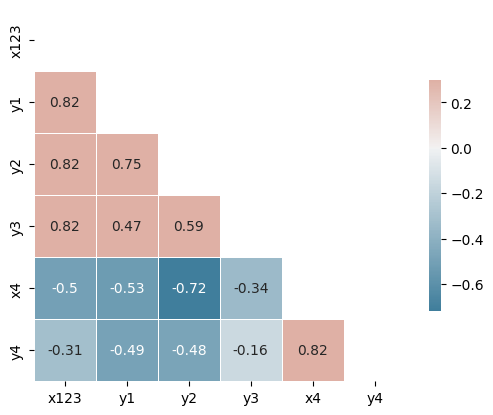

In [5]:
corrplot(quartet_df)

Как видно, корреляции одинаковы. Однако, если построить модели и графики предсказаний, результаты будут знгачительно отличаться.
ЭТакже выведем значения коэффициентов модели.

**Задание**: Постройте линейные модели для каждого из наборов данных, не смотря на графики. Отличаются ли модели?

In [6]:
quartet_df

,x123,y1,y2,y3,x4,y4
0,10.0,8.04,9.14,7.46,8.0,6.58
1,8.0,6.95,8.14,6.77,8.0,5.76
2,13.0,7.58,8.74,12.74,8.0,7.71
3,9.0,8.81,8.77,7.11,8.0,8.84
4,11.0,8.33,9.26,7.81,8.0,8.47
5,14.0,9.96,8.10,8.84,8.0,7.04
6,6.0,7.24,6.13,6.08,8.0,5.25
7,4.0,4.26,3.10,5.39,19.0,12.50
8,12.0,10.84,9.13,8.15,8.0,5.56
9,7.0,4.82,7.26,6.42,8.0,7.91


In [7]:
# Anscombe 1
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y1'])
model_1 = LinearRegression().fit(x, y)
y_pred = model_1.predict(x)
r_sq = model_1.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_1.intercept_}")
print(f"slope: {model_1.coef_}")

coefficient of determination: 0.6665424595087748
intercept: 3.0000909090909094
slope: [0.50009091]


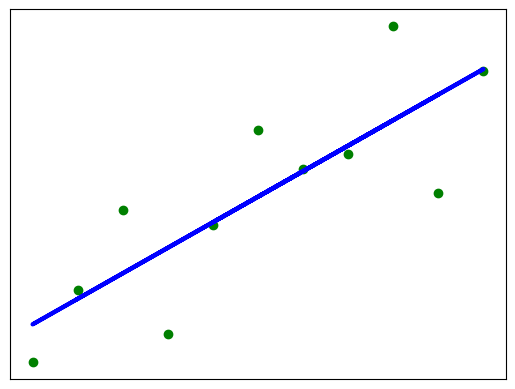

In [8]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [9]:
# Anscombe 2
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y2'])
model_2 = LinearRegression().fit(x, y)
y_pred = model_2.predict(x)
r_sq = model_2.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_2.intercept_}")
print(f"slope: {model_2.coef_}")

coefficient of determination: 0.6662420337274844
intercept: 3.00090909090909
slope: [0.5]


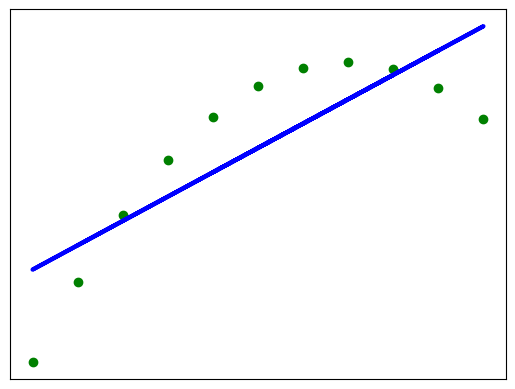

In [10]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [11]:
# Anscombe 3
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y3'])
model_3 = LinearRegression().fit(x, y)
y_pred = model_3.predict(x)
r_sq = model_3.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_3.intercept_}")
print(f"slope: {model_3.coef_}")

coefficient of determination: 0.6663240410665592
intercept: 3.002454545454545
slope: [0.49972727]


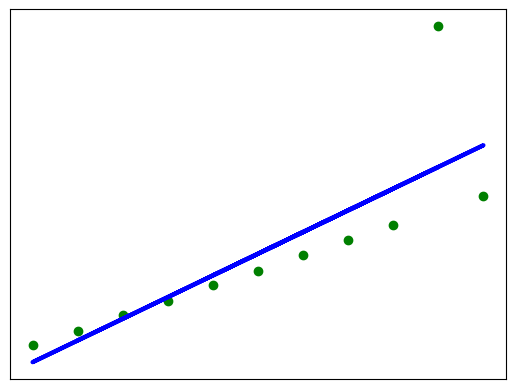

In [12]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [13]:
# Anscombe 4
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y4'])
model_4 = LinearRegression().fit(x, y)
y_pred = model_3.predict(x)
r_sq = model_3.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_4.intercept_}")
print(f"slope: {model_4.coef_}")

coefficient of determination: -1.1788878100103757
intercept: 9.231363636363636
slope: [-0.19227273]


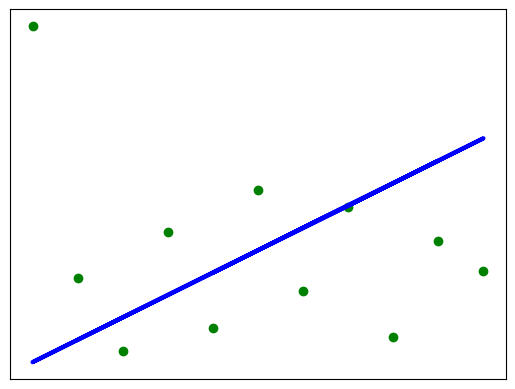

In [14]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

Как видно, все эти зависимости имеют разную природу, но при этом порождают модели с практически одинаковыми параметрами. Таким образом, чрезвычайно важно проводить достаточно объемный EDA.
Датасте же - известный набор [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

# Положения линейной регрессии
Далее рассмотрим некоторые положения линейной регрессии, которые задают границы ее применимости (а также что бывает, когда они нарушаются).

**Линейность**: взаимосвязь между зависимыми и независимыми переменными линейна.

**Независимость**: Наблюдения независимы друг от друга.

**Гомоскедастичность**: дисперсия ошибок постоянна на всех уровнях независимых переменных.

**Нормальность**: ошибки подчиняются нормальному распределению.

**Нет мультиколлинеарности**: независимые переменные не сильно коррелируют друг с другом.

**Нет эндогенности**: между ошибками и независимыми переменными нет связи.

## Нелинейность

Рассмотрим набор данных Bluegills.
В 1981 году n = 78 [cинежаберных солнечников](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B5%D0%B6%D0%B0%D0%B1%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BE%D0%BB%D0%BD%D0%B5%D1%87%D0%BD%D0%B8%D0%BA) были случайным образом отобраны из озера Мэри в Миннесоте (Кук и Вайсберг, 1999):
* Длина (в мм) рыбы
* Возраст (в годах) рыбы


In [15]:
df = pd.read_csv(f"{data_path}/bluegills.txt", sep="\t")

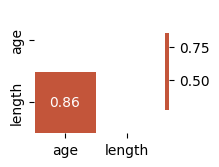

In [16]:
corrplot(df)

Постройте график длины рыбы от возраста 

    age  length
0     1      67
1     1      62
2     2     109
3     2      83
4     2      91
..  ...     ...
73    6     170
74    4     160
75    5     180
76    4     160
77    4     170

[78 rows x 2 columns]


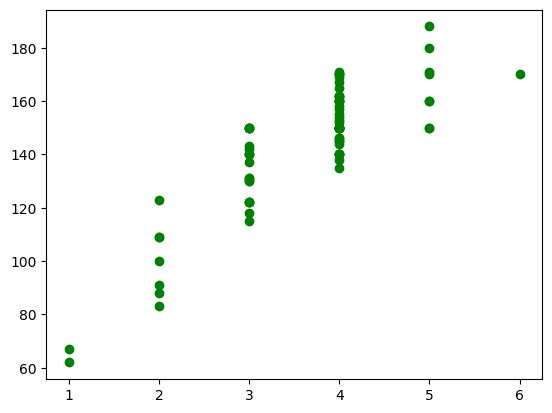

In [17]:
df.sort_values(by=list(df.columns),axis=0)
print(df)
plt.scatter(df['age'], df['length'], color="green")
plt.show()

График позволяет предположить, что в данных наблюдается положительная динамика. Неудивительно, что с увеличением возраста рыб их длина имеет тенденцию к увеличению. Однако эта тенденция не выглядит вполне линейной. Кажется, что отношения слегка искривлены.

Один из способов моделирования кривизны этих данных — сформулировать «полиномиальную модель второго порядка»:

$ Y=\beta_0+ \sum_i (\alpha_i  X_i^2) + \sum_i (\beta_i  X_i) + \sum_{j \neq i} (\gamma_{ij}  X_i X_j) + \epsilon $

Сделать это просто, введя в данные полиномиальные признаки (PolynomialFeatures) и обучив обычную линейную модель.

**Задание**: Обучите обычную и полиномиальную регрессии на рыбах. Постройте графики предсказаний. 
**Доп.задание**: Определите MSE для двух моделей.

In [18]:
X = np.array(df['age']).reshape((-1, 1))
y = np.array(df['length'])
model_basic =  LinearRegression().fit(X, y)
y_basic = model_basic.predict(X)

In [19]:
degree = 2  # Set the polynomial degree
poly_features =  PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(np.array(df['age']).reshape((-1, 1)))

model_poly = LinearRegression().fit(X_poly, y)
# fit model on processed data

y_poly = model_poly.predict(X_poly)

In [20]:
print(f"coefficient of determination of linear model: {model_basic.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of linear model: 0.7348821471782518
coefficient of determination of polynomial model: 0.8011378030846004


In [21]:
y = df['length']
print(f"MSE of linear model: {mean_squared_error(model_basic.predict(X), y)}")
print(f"MSE of polynomial model: {mean_squared_error(model_poly.predict(X_poly), y)}")

MSE of linear model: 152.47226648794904
MSE of polynomial model: 114.36789171210624


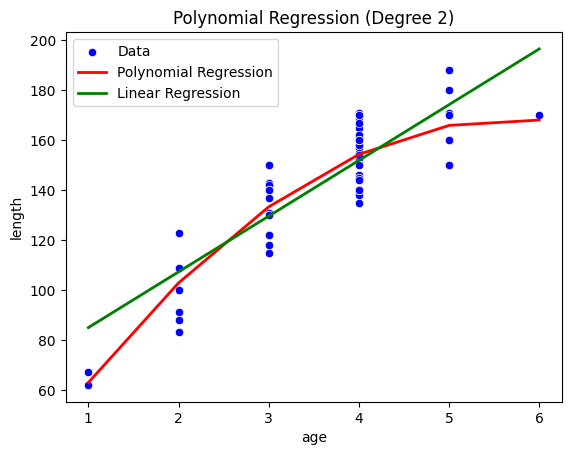

In [22]:
sns.scatterplot(df,x="age", y="length", label='Data', color='blue')
sns.lineplot(x=df["age"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=df["age"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()

**Задание**: Постройте модель с фичами высокой степени.

In [23]:
degree =  30  # Set the polynomial degree
poly_features =  PolynomialFeatures(degree=degree)
X_high_poly = poly_features.fit_transform(np.array(df['age']).reshape((-1, 1)))
model_high_poly = LinearRegression().fit(X_high_poly, y)
# fit model on processed data

y_high_poly = model_high_poly.predict(X_high_poly)

In [24]:
print(f"coefficient of determination of polynomial model with a high degree: {model_high_poly.score(X_high_poly, y)}")
print(f"MSE of polynomial model with a high degree: {mean_squared_error(model_high_poly.predict(X_high_poly), y)}")

coefficient of determination of polynomial model with a high degree: 0.7587915376860904
MSE of polynomial model with a high degree: 138.72170641711645


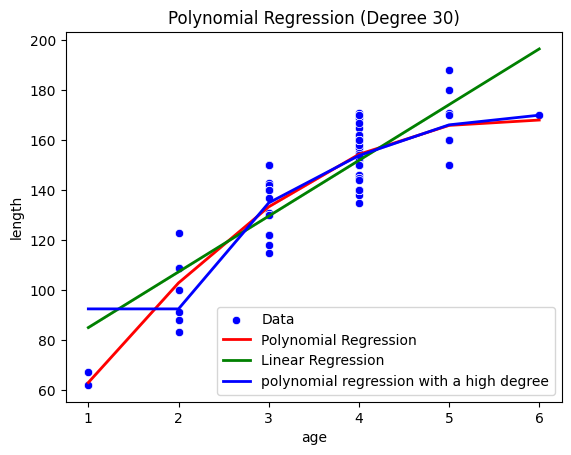

In [25]:
sns.scatterplot(df,x="age", y="length", label='Data', color='blue')
sns.lineplot(x=df["age"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=df["age"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
sns.lineplot(x=df["age"], y=y_high_poly, label='polynomial regression with a high degree', color='blue', linewidth=2)
plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()

**Задание**: Постройте модель для наборов Anscombe 1 и Anscombe 2. Напишите, какие степени полинома подойдут лучше всего.

In [26]:
def get_polynomial_model(X, y, degree: int) -> tuple[LinearRegression, PolynomialFeatures]:
    poly_features =  PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    return LinearRegression().fit(X_poly, y), poly_features

In [27]:
def search_optimal_degree(X, y, MIN_DEGREE, MAX_DEGREE, model_getter) -> pd.DataFrame:
    model_results = np.zeros(shape=(MAX_DEGREE + 1 - MIN_DEGREE, 2))
    
    for idx, degree in enumerate(range(MIN_DEGREE, MAX_DEGREE + 1)):
        model, poly_features = model_getter(X, y, degree)
        X_poly = poly_features.transform(X)
        model_results[idx][0] = model.score(X_poly, y)
        model_results[idx][1] = mean_squared_error(model.predict(X_poly), y)
        
    degrees = np.arange(MIN_DEGREE, MAX_DEGREE + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.barplot(x=degrees, y=model_results[:, 0], ax=ax[0])
    ax[0].set_title("R² Score vs Degree")
    ax[0].set_xlabel("Polynomial Degree")
    ax[0].set_ylabel("R² Score")

    sns.barplot(x=degrees, y=model_results[:, 1], ax=ax[1])
    ax[1].set_title("MSE vs Degree")
    ax[1].set_xlabel("Polynomial Degree")
    ax[1].set_ylabel("MSE")

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(model_results, columns=['score', 'MSE'], index=degrees)
    
    
        

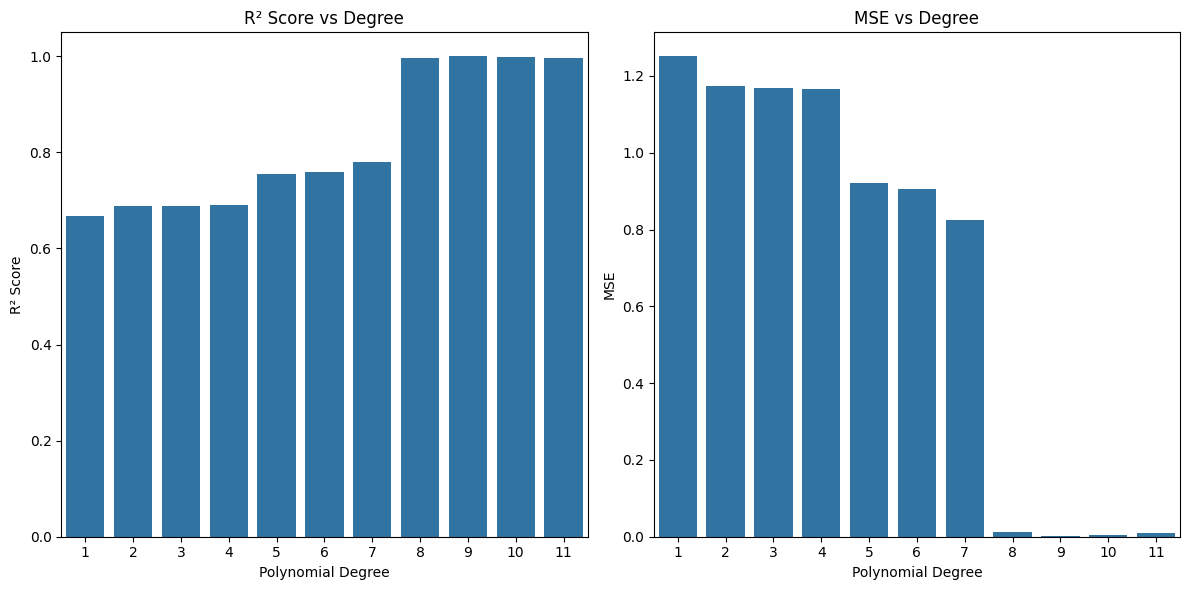

,score,MSE
1,0.666542,1.251154
2,0.687327,1.173167
3,0.688700,1.168017
4,0.689488,1.165060
5,0.754759,0.920159
6,0.758616,0.905689
7,0.780363,0.824093
8,0.996682,0.012449
9,0.999691,0.001159
10,0.998917,0.004063


In [28]:
MIN_DEGREE = 1
MAX_DEGREE = 11
X = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y1'])

results = search_optimal_degree(X, y, MIN_DEGREE, MAX_DEGREE, get_polynomial_model)
results

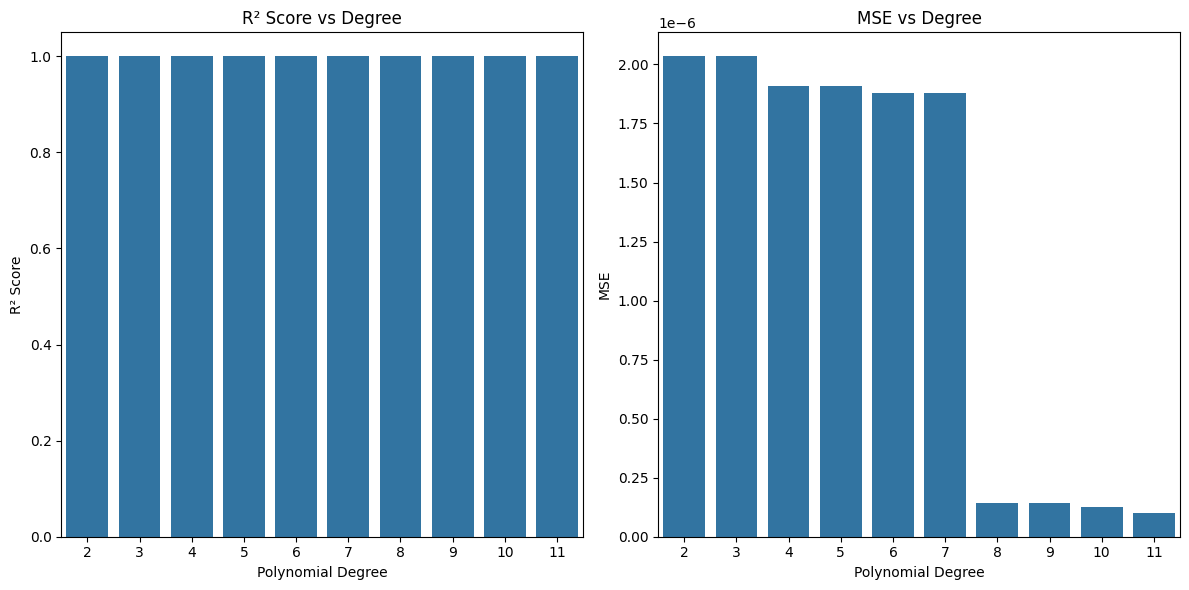

,score,MSE
2,0.999999,2.034329e-06
3,0.999999,2.034329e-06
4,0.999999,1.907184e-06
5,0.999999,1.907184e-06
6,0.999999,1.878015e-06
7,0.999999,1.878015e-06
8,1.000000,1.434817e-07
9,1.000000,1.435621e-07
10,1.000000,1.255895e-07
11,1.000000,1.013202e-07


In [29]:
MIN_DEGREE = 2
MAX_DEGREE = 11
X = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y2'])

results = search_optimal_degree(X, y, MIN_DEGREE, MAX_DEGREE, get_polynomial_model)
results

**Вывод:** Наилучшие степени полиномов для наборов данных Anscombe 1 и Anscombe 2 8 и 11 соответственно

**Задание со звездочкой**: Постройте модель с использованием другого базиса, не полиномиального. Проиллюстрируйте ее применение на примерах из практики.

In [30]:

class FourierFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree: int):
        self.degree = degree

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.flatten()
        features = [np.ones_like(X)]
        
        for k in range(1, self.degree + 1):
            features.append(np.sin(k * X))
            features.append(np.cos(k * X))
        
        return np.column_stack(features)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
def get_fourier_model(X, y, degree: int) -> tuple[LinearRegression, PolynomialFeatures]:
    poly_features =  FourierFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    return LinearRegression().fit(X_poly, y), poly_features


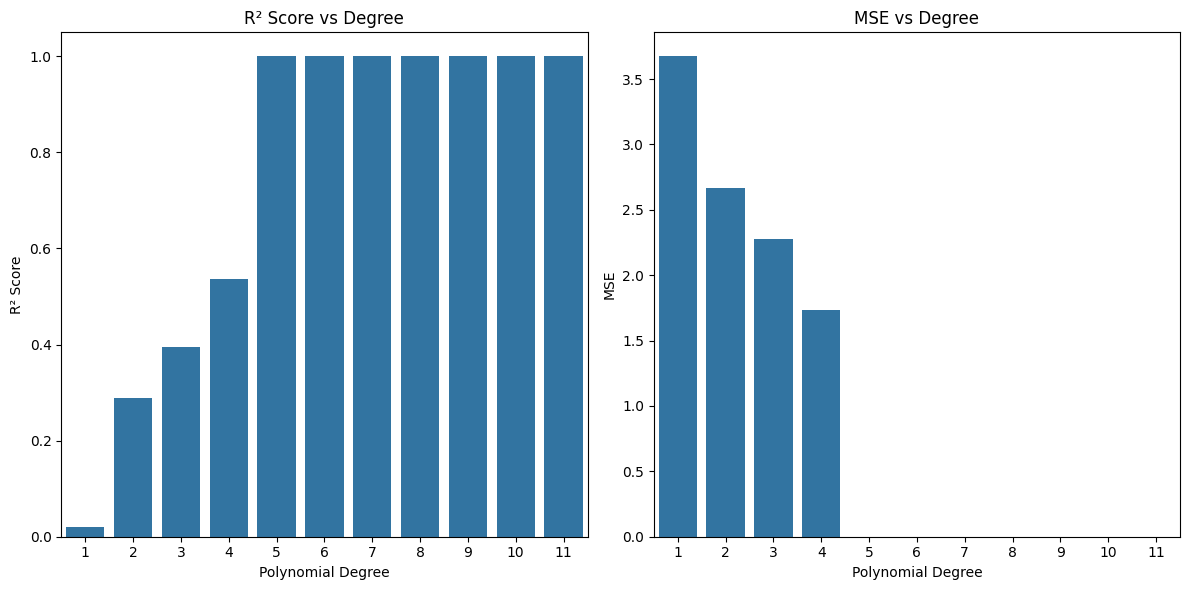

,score,MSE
1,0.020810,3.673981e+00
2,0.288318,2.670277e+00
3,0.394088,2.273421e+00
4,0.537543,1.735169e+00
5,1.000000,1.154606e-29
6,1.000000,6.526031e-30
7,1.000000,6.024029e-30
8,1.000000,4.797709e-29
9,1.000000,1.742665e-29
10,1.000000,8.175468e-30


In [31]:
MIN_DEGREE = 1
MAX_DEGREE = 11
X = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y1'])

results = search_optimal_degree(X, y, MIN_DEGREE, MAX_DEGREE, get_fourier_model)
results

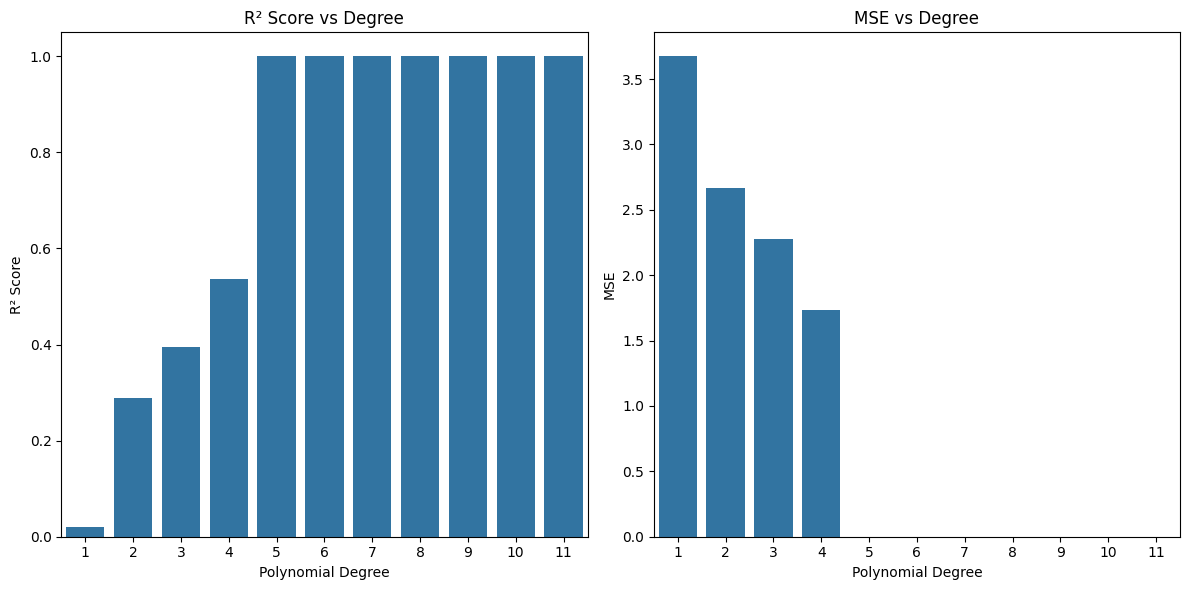

,score,MSE
1,0.020810,3.673981e+00
2,0.288318,2.670277e+00
3,0.394088,2.273421e+00
4,0.537543,1.735169e+00
5,1.000000,1.154606e-29
6,1.000000,6.526031e-30
7,1.000000,6.024029e-30
8,1.000000,4.797709e-29
9,1.000000,1.742665e-29
10,1.000000,8.175468e-30


In [32]:
MIN_DEGREE = 1
MAX_DEGREE = 11
X = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y1'])

results = search_optimal_degree(X, y, MIN_DEGREE, MAX_DEGREE, get_fourier_model)
results

**Выод:** Использование фурьк-базиса помогло улучшить картину

## Выбросы
Как мы уже видели, выбросы могут сильно влиять на предсказания линейной модели. Даже один выброс может нарушить одно из условий линейной регрессии. К счастью, существует много способов с ними бороться.
Простейший вариант - использовать не MSE, а MAE. Почему?
Однако есть и более сложные варианты. Например, комбинация MSE и MAE дает **HuberLoss**.

Другой робастный вариант - **Theil-Sen regression**. Этот метод строит медиану наклона модели между всеми парами наблюдений. Проблема этого метода в том, что для больших наборов данных вычислительная сложность метода становится слишком большой.

Третий метод: **RANSAC**. В этом методе итеративно берутся подвыборки заданного размера, строятся модели и считаются расстояния от предсказания до реальной точки. Далее точки, для которых расстояние меньше некоторой границы, считаются доверенными. На этих данных обучается новая модель-кандидат. В качестве финальной используется лучший кандидат. Однако данный метод подходит только для моделей, которые не требуют очень большого количества данных.

Рассмотрим синтетические данные. Пусть это будут синусоидальные данные, но некоторые наблюдения будут "испорчены"

In [33]:
X = np.random.uniform(0, 1.5, size=300)
y = np.sin(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)
X = X.reshape(-1,1)

X_test = np.random.uniform(0, 1.5, size=300) 
y_test = np.sin(1.5 * np.pi * X_test) + np.random.normal(scale=0.1, size=X_test.shape)
X_test = X_test.reshape(-1,1)

y_errors = y.copy()
y_errors[::5] = 3

X_errors = X.copy()
X_errors[::5] = 3

y_errors_large = y.copy()
y_errors_large[::5] = 10

X_errors_large = X.copy()
X_errors_large[::5] = 10

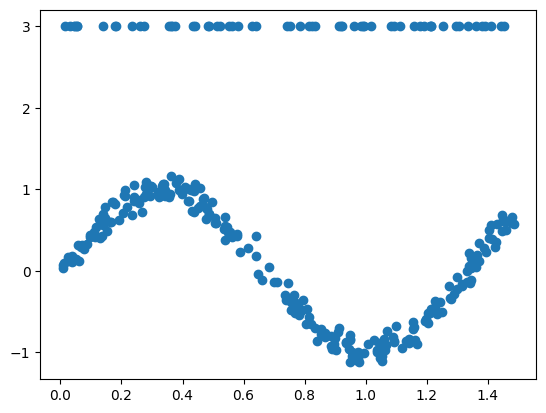

In [34]:
plt.scatter(X, y_errors)

**Задание**: Последовательно постройте различные модели для разных видов испорченности данных.

/tmp/ipykernel_4735/2350181216.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict)])


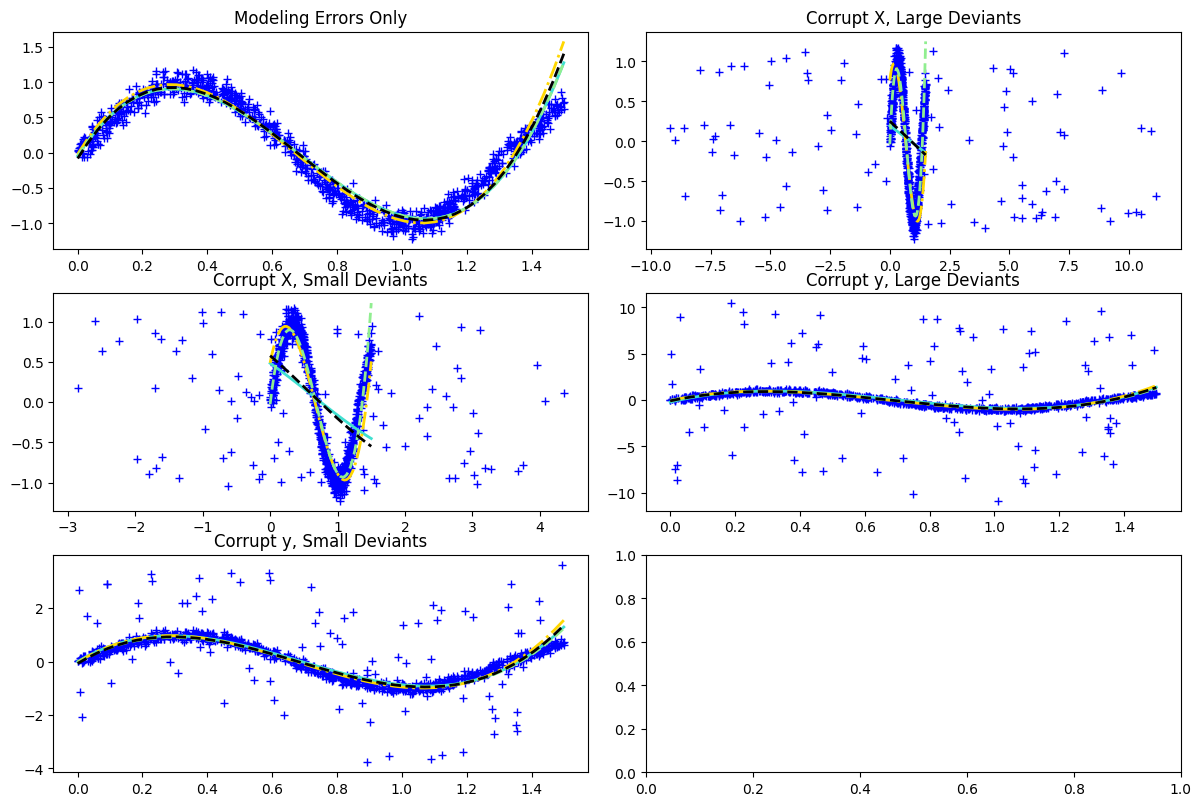

In [167]:
estimators = {
    "OLS": LinearRegression(),
    "Theil-Sen": TheilSenRegressor(random_state=42),
    "RANSAC": RANSACRegressor(random_state=42),
    "Huber": HuberRegressor(),
}

colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "Huber": "--"}
lw = 2
fig, ax = plt.subplots(nrows=3, ncols=2, figsize= (12,8))
fig.tight_layout()
x_plot = np.linspace(X.min(), X.max())
time_dict = {name: 0. for name in estimators.keys()}
errors_df = pd.DataFrame(columns = list(estimators.keys()))
time_dict["Problem"] = "Sum time"
for i, (title, this_X, this_y) in enumerate([
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]):
    ax[i % 3, i // 3].plot(this_X[:, 0], this_y, "b+")
    errors_dict = {"Problem": title}
    for name, estimator in estimators.items():
        model = make_pipeline(PolynomialFeatures(degree=3), estimator)
        t0 = time.time()
        model.fit(this_X, this_y)
        time_dict[name] += time.time() - t0
        mse = np.mean((model.predict(this_X) - this_y)**2)
        errors_dict[name] = [mse]
        y_plot = model.predict(x_plot[:, np.newaxis])
        ax[i % 3, i // 3].plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )
    errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict)])
    ax[i % 3, i // 3].title.set_text(title)
errors_df = pd.concat([errors_df, pd.DataFrame(time_dict, index=[0])]) 
plt.show()

In [36]:
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

In [37]:
errors_df

,OLS,Theil-Sen,RANSAC,Huber,Problem
0,0.025906,0.028332,2.686590e-02,0.026981,Modeling Errors Only
0,0.335633,23.865023,1.810438e+03,0.336670,"Corrupt X, Small Deviants"
0,1.518852,1.746348,1.911027e+00,1.838582,"Corrupt y, Small Deviants"
0,0.322710,65413.988635,8.986909e+06,0.325747,"Corrupt X, Large Deviants"
0,16.022225,19.408312,2.011123e+01,19.861143,"Corrupt y, Large Deviants"
0,0.004392,0.989367,3.142715e-02,0.028697,Sum time


**Задание**: Поиграйте с этими датасетами и параметрами моделей. 
Ответьте на вопросы:
- При каких размерах датасетов лучше использовать каждый из алгоритмов
- При каких процентах выбросов и их значениях лучше использовать каждый из алгоритмов
- Влияет ли то, как распределены выбросы, на выбор метода
- Влияет ли отношение шума к сигналу на выбор алгоритма
- Какие алгоритмы более чувствительны к параметрам, какие менее
Для ответов покажите таблицы и/или графики

In [138]:
from typing import Tuple, Literal

def get_data(
    size: int,
    outlier_proportion: float | None = None,
    outlier_error: float | None = None,
    outlier_error_large: float | None = None,
    outlier_distribution: Literal["normal", "uniform", "exponential", "logistic"] = "normal",
) -> Tuple[NDArray, NDArray, NDArray, NDArray, NDArray, NDArray, NDArray, NDArray]:
    """
    Генерация датасета с возможностью добавления выбросов.

    Параметры:
    -----------
    size : int
        Размер датасета.
    outlier_proportion : float | None, optional
        Доля выбросов в данных. Если None, выбросы не добавляются.
    outlier_error : float | None, optional
        Параметр для генерации маленьких выбросов (зависит от распределения).
    outlier_error_large : float | None, optional
        Параметр для генерации больших выбросов (зависит от распределения).
    outlier_distribution : str, optional
        Тип распределения выбросов: "normal" (нормальное), "uniform" (равномерное),
        "exponential" (экспоненциальное), "logistic" (логистическое).
        По умолчанию "normal".

    Возвращает:
    -----------
    tuple[NDArray]
        X, y, X_test, y_test, X_errors, y_errors, X_errors_large, y_errors_large
    """
    # Генерация основного датасета
    X = np.random.uniform(0, 1.5, size=size)
    y = np.sin(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=size)
    X = X.reshape(-1, 1)

    # Генерация тестового датасета
    X_test = np.random.uniform(0, 1.5, size=size)
    y_test = np.sin(1.5 * np.pi * X_test) + np.random.normal(scale=0.1, size=size)
    X_test = X_test.reshape(-1, 1)

    # Инициализация переменных для датасетов с выбросами
    X_errors, y_errors = X.copy(), y.copy()
    X_errors_large, y_errors_large = X.copy(), y.copy()

    # Добавление выбросов, если заданы параметры
    if outlier_proportion is not None:
        n_outliers = int(size * outlier_proportion)  # Количество выбросов
        outlier_indices = np.random.choice(size, n_outliers, replace=False)

        # Генерация выбросов в соответствии с заданным распределением
        if outlier_distribution == "normal":
            if outlier_error is not None:
                y_errors[outlier_indices] += np.random.normal(scale=outlier_error, size=n_outliers)
                X_errors[outlier_indices] += np.random.normal(scale=outlier_error, size=n_outliers).reshape(-1, 1)
            if outlier_error_large is not None:
                y_errors_large[outlier_indices] += np.random.normal(scale=outlier_error_large, size=n_outliers)
                X_errors_large[outlier_indices] += np.random.normal(scale=outlier_error_large, size=n_outliers).reshape(-1, 1)
        elif outlier_distribution == "uniform":
            if outlier_error is not None:
                y_errors[outlier_indices] += np.random.uniform(-outlier_error, outlier_error, size=n_outliers)
                X_errors[outlier_indices] += np.random.uniform(-outlier_error, outlier_error, size=n_outliers).reshape(-1, 1)
            if outlier_error_large is not None:
                y_errors_large[outlier_indices] += np.random.uniform(-outlier_error_large, outlier_error_large, size=n_outliers)
                X_errors_large[outlier_indices] += np.random.uniform(-outlier_error_large, outlier_error_large, size=n_outliers).reshape(-1, 1)
        elif outlier_distribution == "exponential":
            if outlier_error is not None:
                y_errors[outlier_indices] += np.random.exponential(scale=outlier_error, size=n_outliers)
                X_errors[outlier_indices] += np.random.exponential(scale=outlier_error, size=n_outliers).reshape(-1, 1)
            if outlier_error_large is not None:
                y_errors_large[outlier_indices] += np.random.exponential(scale=outlier_error_large, size=n_outliers)
                X_errors_large[outlier_indices] += np.random.exponential(scale=outlier_error_large, size=n_outliers).reshape(-1, 1)
        elif outlier_distribution == "logistic":
            if outlier_error is not None:
                y_errors[outlier_indices] += np.random.logistic(scale=outlier_error, size=n_outliers)
                X_errors[outlier_indices] += np.random.logistic(scale=outlier_error, size=n_outliers).reshape(-1, 1)
            if outlier_error_large is not None:
                y_errors_large[outlier_indices] += np.random.logistic(scale=outlier_error_large, size=n_outliers)
                X_errors_large[outlier_indices] += np.random.logistic(scale=outlier_error_large, size=n_outliers).reshape(-1, 1)
        else:
            raise ValueError("Неподдерживаемое распределение выбросов.")

    return X, y, X_test, y_test, X_errors, y_errors, X_errors_large, y_errors_large

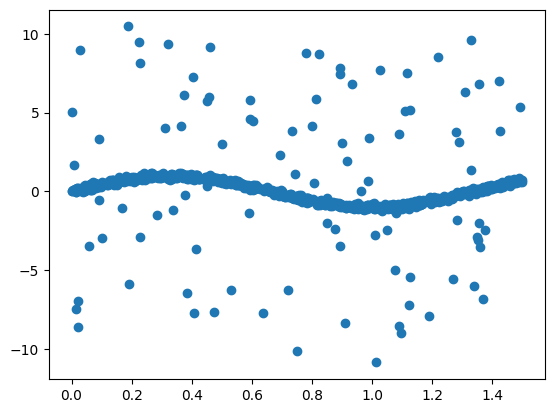

In [139]:
X, y, X_test, y_test, X_errors, y_errors, X_errors_large, y_errors_large = get_data(
    size=1000,
    outlier_proportion=0.1,
    outlier_error=3.0,
    outlier_error_large=10.0,
    outlier_distribution="uniform"
)
plt.scatter(X, y_errors_large)

In [162]:
def test_data(data: tuple) -> pd.DataFrame:
    X, y, X_test, y_test, X_errors, y_errors, X_errors_large, y_errors_large = data
    estimators = {
        "OLS": LinearRegression(),
        "Theil-Sen": TheilSenRegressor(random_state=42),
        "RANSAC": RANSACRegressor(random_state=42),
        "Huber": HuberRegressor(),
    }
    
    results = pd.DataFrame(columns=list(estimators.keys()) + ["type_data"])
    
    for i, (data_name, this_X, this_y) in enumerate([
        ("X, y", X, y),
        ("X_errors, y", X_errors, y),
        ("X, y_errors", X, y_errors),
        ("X_errors_large, y", X_errors_large, y),
        ("X, y_errors_large", X, y_errors_large),
    ]):
        data_results = pd.DataFrame(columns=list(estimators.keys()) + ["type_data"], 
                                   index=["time_fit", "R2", "MSE"])
        
        for est_name, estimator in estimators.items():
            model = make_pipeline(PolynomialFeatures(degree=3), estimator)
            t0 = time.time()
            model.fit(this_X, this_y)
            t1 = time.time()
            y_pred = model.predict(X)
            mse = mean_squared_error(y_pred, this_y)
            r2_score = model.score(X, this_y)
            data_results[est_name] = [t1 - t0, r2_score, mse]
        
        data_results["type_data"] = data_name
        results = pd.concat([results, data_results], axis=0)
        
    return results

/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, data_results], axis=0)
/tmp/ipykernel_4735/402765852.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[key][estimator][parameter].append(results.loc[parameter, estimator][0])
/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old beh

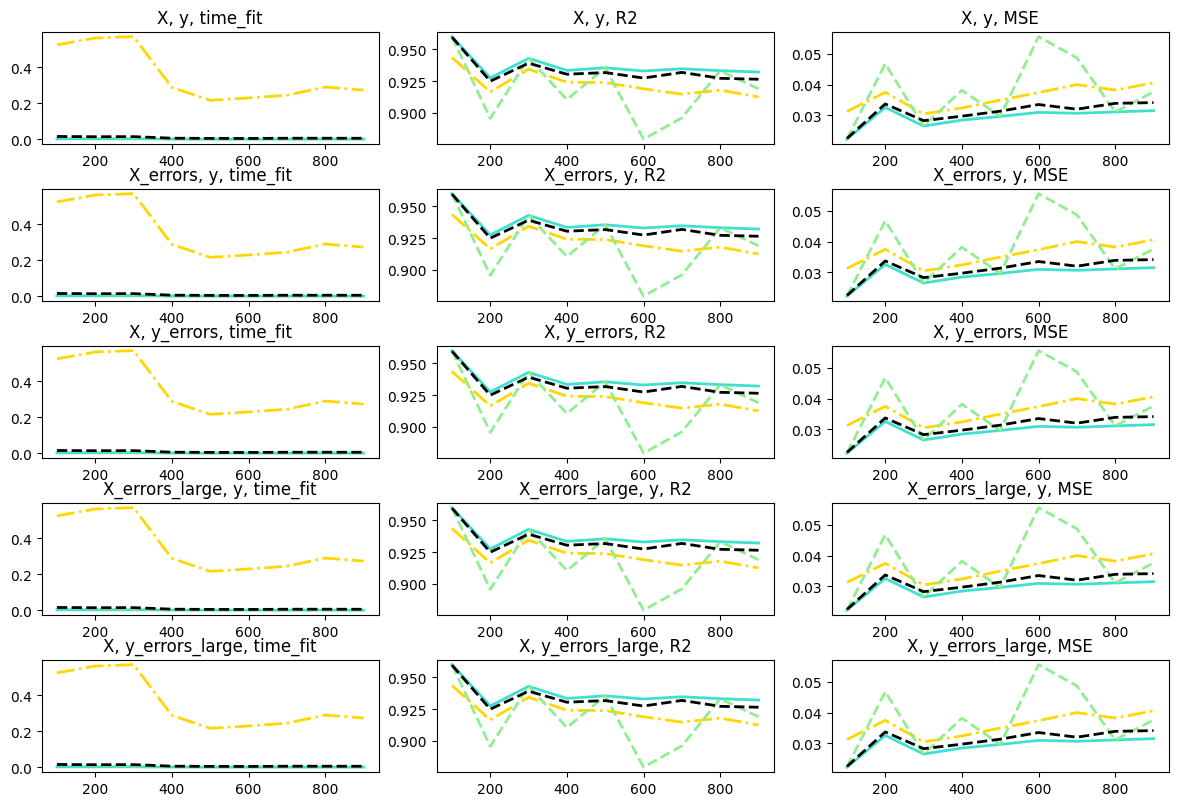

In [198]:
results = None
parametres = ["time_fit", "R2", "MSE"]
data = dict.fromkeys(["X, y", "X_errors, y", "X, y_errors", "X_errors_large, y", "X, y_errors_large"])

for key in data.keys():
    data[key] = dict.fromkeys(estimators.keys())
    
    for name in estimators.keys():
        data[key][name] = dict.fromkeys(parametres)
        
        for parameter in parametres:
            data[key][name][parameter] = []
    

for size in range(10**2, 10**3, 100):
    results = test_data(
        get_data(
            size=size,
            outlier_proportion=0.1,
            outlier_error=3.0,
            outlier_error_large=10.0,
            outlier_distribution="uniform"
        )
    )
    for key in data.keys():
        data_results = results[results['type_data'] == key]
        for estimator in estimators.keys():
            for parameter in parametres:
                data[key][estimator][parameter].append(results.loc[parameter, estimator][0])   
                
                
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

fig, ax = plt.subplots(nrows=5, ncols=3, figsize= (12,8))
fig.tight_layout()

x_plot = [size for size in range(10**2, 10**3, 100)]

for data_idx, data_key in enumerate(data.keys()):
    for param_idx, param_key in enumerate(parametres):
        ax[data_idx, param_idx].title.set_text(f"{data_key}, {param_key}")
        for estimator in estimators.keys():
            ax[data_idx, param_idx].plot(
                x_plot,
                data[data_key][estimator][param_key],
                color=colors[estimator],
                linestyle=linestyle[estimator],
                linewidth=lw,
            )
            
plt.show()       

/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, data_results], axis=0)
/tmp/ipykernel_4735/4047491051.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[key][estimator][parameter].append(results.loc[parameter, estimator][0])
/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old be

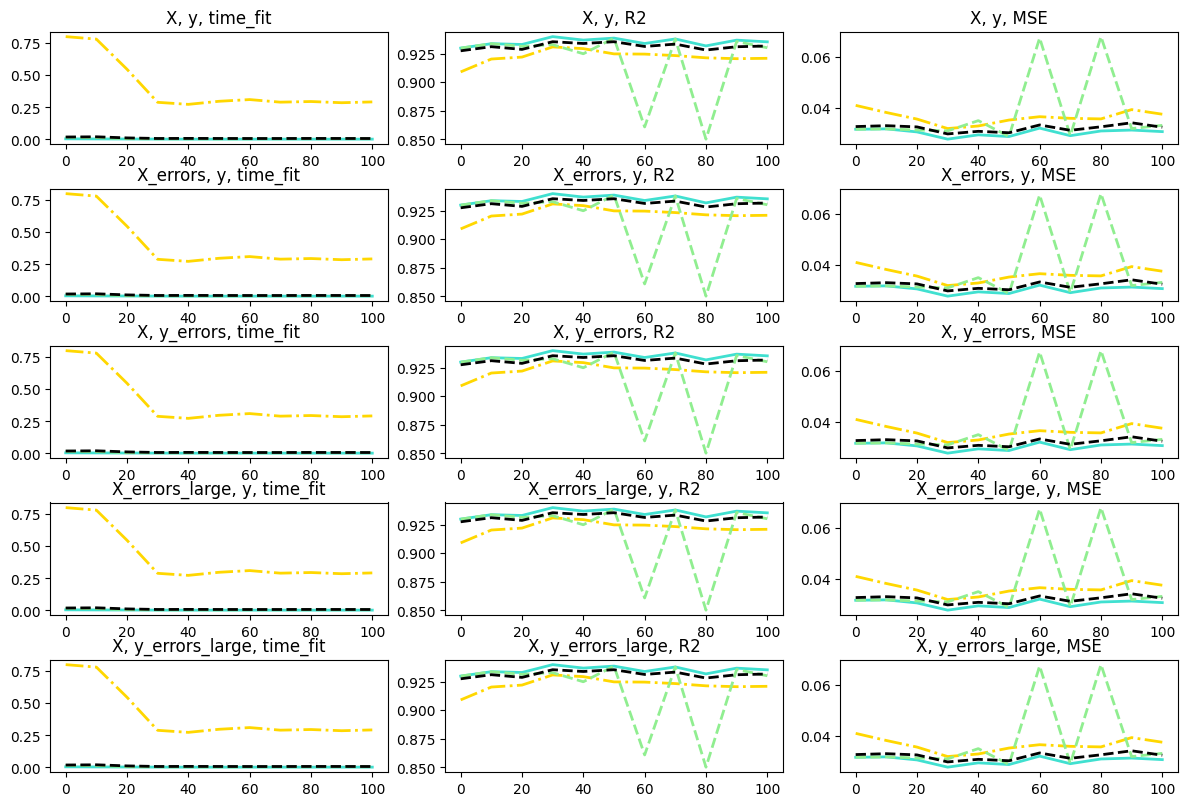

In [200]:
results = None
parametres = ["time_fit", "R2", "MSE"]
data = dict.fromkeys(["X, y", "X_errors, y", "X, y_errors", "X_errors_large, y", "X, y_errors_large"])

for key in data.keys():
    data[key] = dict.fromkeys(estimators.keys())
    
    for name in estimators.keys():
        data[key][name] = dict.fromkeys(parametres)
        
        for parameter in parametres:
            data[key][name][parameter] = []
    

for persentage in range(0, 100 + 1, 10):
    results = test_data(
        get_data(
            size=1000,
            outlier_proportion = persentage // 100,
            outlier_error=3.0,
            outlier_error_large=10.0,
            outlier_distribution="uniform"
        )
    )
    for key in data.keys():
        data_results = results[results['type_data'] == key]
        for estimator in estimators.keys():
            for parameter in parametres:
                data[key][estimator][parameter].append(results.loc[parameter, estimator][0])   
                
                
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

fig, ax = plt.subplots(nrows=5, ncols=3, figsize= (12,8))
fig.tight_layout()

x_plot = [persentage for persentage in range(0, 100 + 1, 10)]

for data_idx, data_key in enumerate(data.keys()):
    for param_idx, param_key in enumerate(parametres):
        ax[data_idx, param_idx].title.set_text(f"{data_key}, {param_key}")
        for estimator in estimators.keys():
            ax[data_idx, param_idx].plot(
                x_plot,
                data[data_key][estimator][param_key],
                color=colors[estimator],
                linestyle=linestyle[estimator],
                linewidth=lw,
            )
            
plt.show()       

/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, data_results], axis=0)
/tmp/ipykernel_4735/1526031014.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[key][estimator][parameter].append(results.loc[parameter, estimator][0])
/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old be

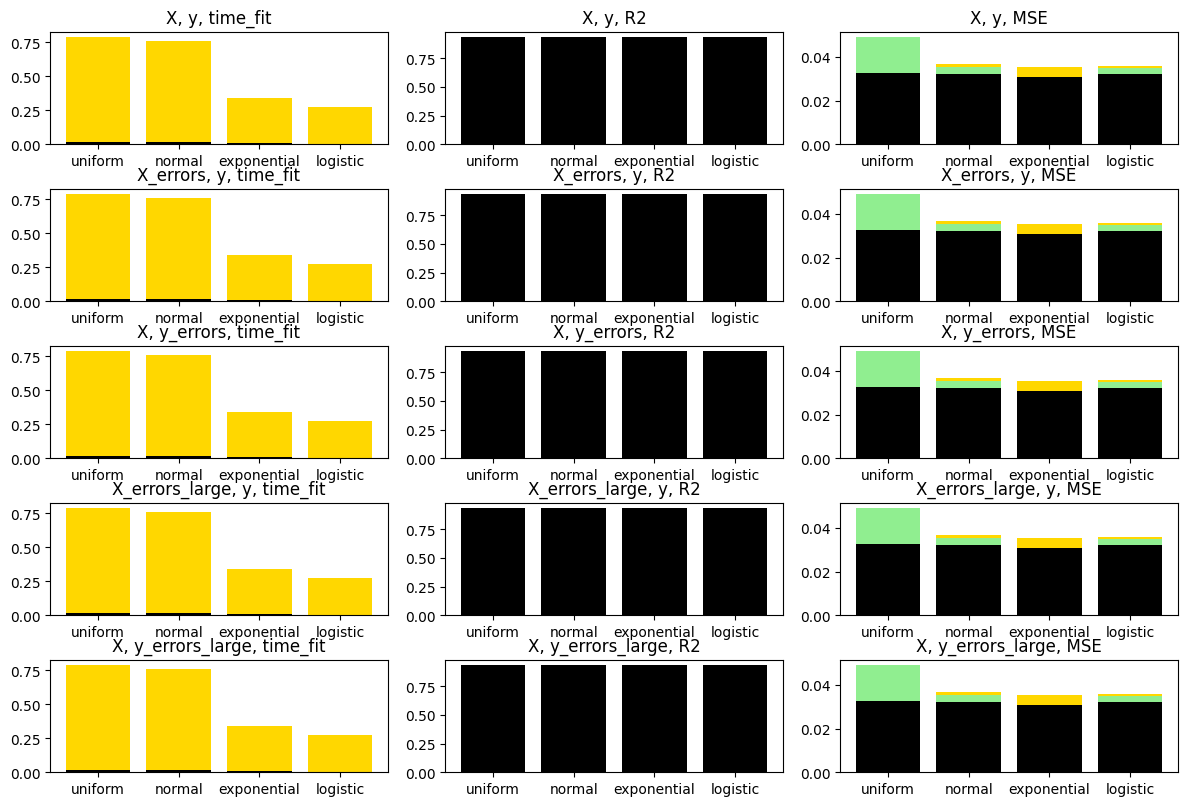

In [203]:
results = None
parametres = ["time_fit", "R2", "MSE"]
data = dict.fromkeys(["X, y", "X_errors, y", "X, y_errors", "X_errors_large, y", "X, y_errors_large"])

for key in data.keys():
    data[key] = dict.fromkeys(estimators.keys())
    
    for name in estimators.keys():
        data[key][name] = dict.fromkeys(parametres)
        
        for parameter in parametres:
            data[key][name][parameter] = []
    

for distribution in ['uniform', 'normal', 'exponential', 'logistic']:
    results = test_data(
        get_data(
            size=1000,
            outlier_proportion=0.1,
            outlier_error=3.0,
            outlier_error_large=10.0,
            outlier_distribution=distribution
        )
    )
    for key in data.keys():
        data_results = results[results['type_data'] == key]
        for estimator in estimators.keys():
            for parameter in parametres:
                data[key][estimator][parameter].append(results.loc[parameter, estimator][0])   
                
                
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

fig, ax = plt.subplots(nrows=5, ncols=3, figsize= (12,8))
fig.tight_layout()

x_plot = [distribution for distribution in ['uniform', 'normal', 'exponential', 'logistic']]

for data_idx, data_key in enumerate(data.keys()):
    for param_idx, param_key in enumerate(parametres):
        ax[data_idx, param_idx].title.set_text(f"{data_key}, {param_key}")
        for estimator in estimators.keys():
            ax[data_idx, param_idx].bar(
                x_plot,
                data[data_key][estimator][param_key],
                color=colors[estimator],
                linestyle=linestyle[estimator],
                linewidth=lw,
            )
            
plt.show()       

/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, data_results], axis=0)
/tmp/ipykernel_4735/366104611.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[key][estimator][parameter].append(results.loc[parameter, estimator][0])
/tmp/ipykernel_4735/136721063.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old beh

19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19


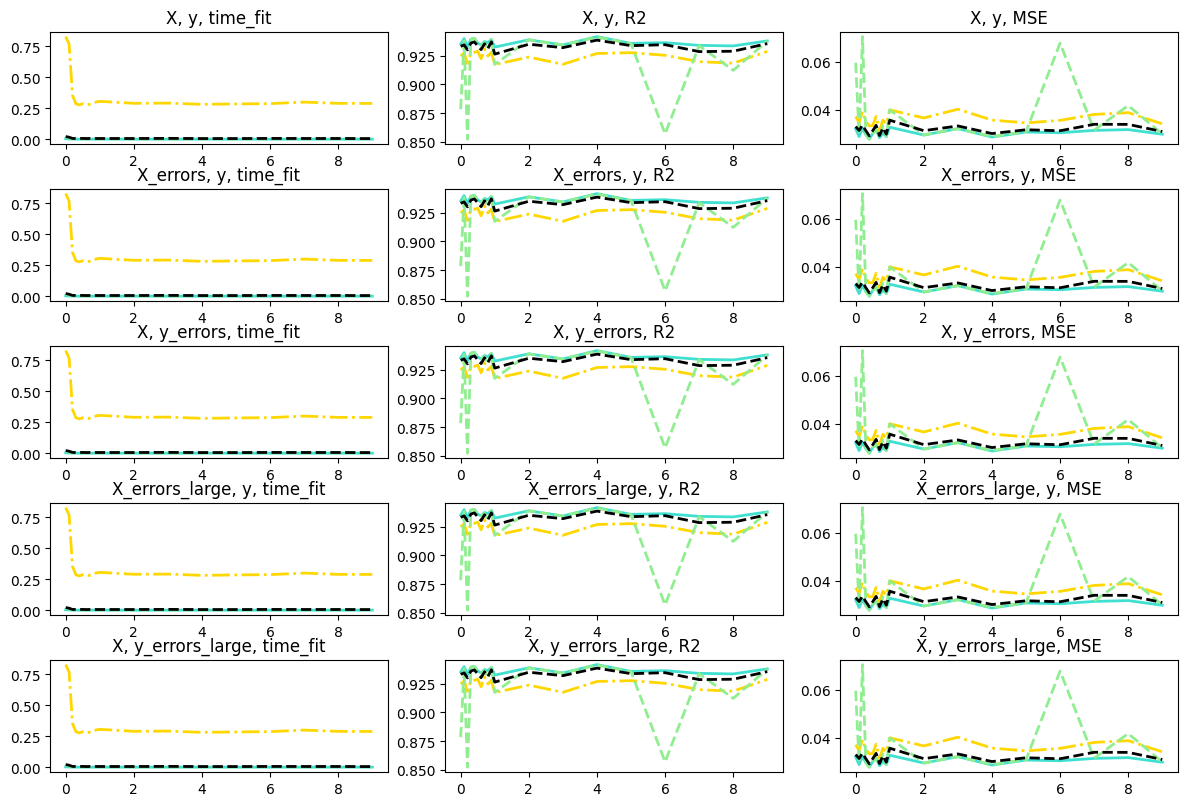

In [211]:
results = None
parametres = ["time_fit", "R2", "MSE"]
data = dict.fromkeys(["X, y", "X_errors, y", "X, y_errors", "X_errors_large, y", "X, y_errors_large"])

for key in data.keys():
    data[key] = dict.fromkeys(estimators.keys())
    
    for name in estimators.keys():
        data[key][name] = dict.fromkeys(parametres)
        
        for parameter in parametres:
            data[key][name][parameter] = []
    

for scale in [x / 10 for x in range(20)]:
    results = test_data(
        get_data(
            size=1000,
            outlier_proportion=0.3,
            outlier_error = scale,
            outlier_error_large = scale * 10,
            outlier_distribution=distribution
        )
    )
    for key in data.keys():
        data_results = results[results['type_data'] == key]
        for estimator in estimators.keys():
            for parameter in parametres:
                data[key][estimator][parameter].append(results.loc[parameter, estimator][0])   
                
                
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

fig, ax = plt.subplots(nrows=5, ncols=3, figsize= (12,8))
fig.tight_layout()

x_plot = [scale for scale in [x / 10 for x in range(20)]]

for data_idx, data_key in enumerate(data.keys()):
    for param_idx, param_key in enumerate(parametres):
        ax[data_idx, param_idx].title.set_text(f"{data_key}, {param_key}")
        for estimator in estimators.keys():
            ax[data_idx, param_idx].plot(
                x_plot,
                data[data_key][estimator][param_key],
                color=colors[estimator],
                linestyle=linestyle[estimator],
                linewidth=lw,
            )
            
plt.show()       

**Вывод:**

## Гетероскедастичность

- **Вопрос 1**: Что такое гетероскедастичность?
- **Вопрос 2**: Какие последствия гетероскедастичности - почему положение о гомоскедачности так важно? 
- **Вопрос 3**: Мы наблюдаем гетероскедастичсность. Предложите примеры гетероскедастичности. В каких  случаях это нарушение возникает из-за нарушения других положений? 

В этой части рассмотрим данные о стоимости домовладения. При этом будем использовать следующие признаки:
* Y = стоимость дома
* X1 = площадь дома
* X2 = площадь участка
Подмножество набора данных об исследовании американского сообщества, полученного из Бюро переписей США.

In [41]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t") # pd.read_csv(f"{data_path}/realestate.csv").dropna()

In [42]:
# Делаем доп.датасет со всеми положениями
linear_X, linear_y = datasets.make_regression(n_samples=data.shape[0],
                                              n_features=data.shape[1],
                                              noise=75, random_state=42)

# Setting feature names to x1, x2, x3, etc. if they are not defined
linear_feature_names = ['X'+str(feature+1) for feature in range(linear_X.shape[1])]

In [43]:
data.columns

Index(['SalePrice', 'SqFeet', 'Beds', 'Baths', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway'],
      dtype='object')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data[["SqFeet"]], np.log(data["SalePrice"]), random_state=42, test_size=0.2)

Если провести регрессионный анализ и оценить график остатков в сравнении с предсказанными значениями, можно отметить несколько «коническую» форму остатков.

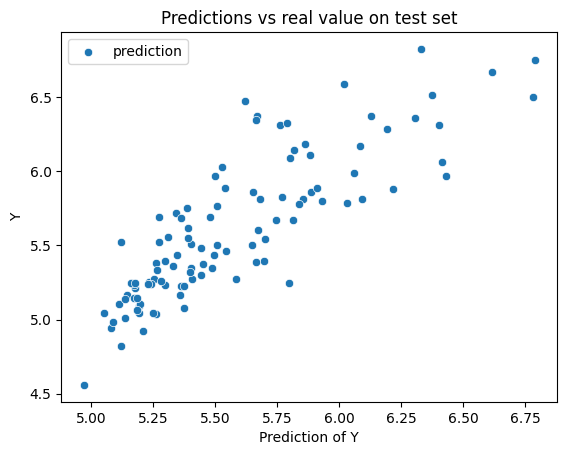

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
sns.scatterplot(x=preds, y=y_test, label="prediction")
plt.xlabel('Prediction of Y')
plt.ylabel('Y')
plt.legend()
plt.title(f'Predictions vs real value on test set')
plt.show()

In [46]:
print(f"The score of prediction is: {model.score(X_test, y_test)}")

The score of prediction is: 0.7045064969984018


Другой способ построить график остатков предлагает Sklearn

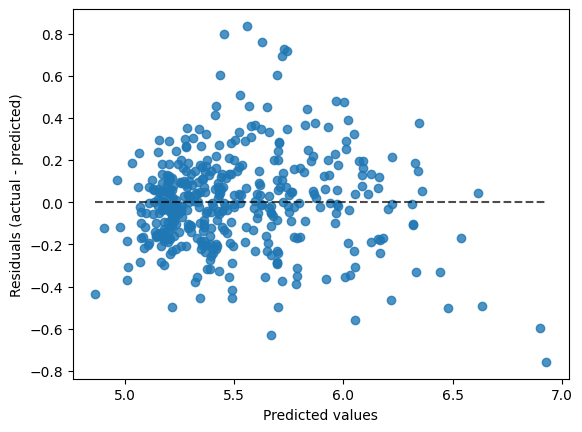

In [47]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_train, y_pred=model.predict(X_train))
display.plot()
plt.show()

Более объективную оценку могут дать специальные статистические тесты, например, тест Уайта или тест Брейша-Пагана

In [48]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd

Тест Бреуша-Пагана  можно выполнить с помощью функции het_breuschpagan модуля statsmodels.stats.diagnostic для оценки того, объясняют ли независимые переменные дисперсию ошибок. Основные параметры функции het_breuschpagan resid - остатки модели, а exog_het — независимые переменные. Обратите внимание, что ему нужна также константная переменная. 
Этот тест проверяет нулевую гипотезу о том, что все дисперсии ошибок равны, в сравнении с альтернативой, согласно которой дисперсии ошибок являются мультипликативной функцией одной или нескольких переменных. Этот тест затрагивает линейную форму гетероскедастичности.

Тест Уайта (het_white) оценивает то, объясняют ли независимые переменные линейной регрессии, квадратичные независимые переменные и перемножения независимых переменных дисперсию ошибок. Он не накладывает ограничений на форму гетероскедастичности.  Внутри происходит регрессия квадратов остатков по отношению к исодным переменным, их квадратам и попарным произведениям. Он более обзий как раз из-за добавления дополнительных переменных. Например, квадраты позволяют найти гетероскедастичность в форме "песочных часов". Однако, у него есть минус в том, что исходная гипотеза разбивается на несколько.

**Вопрос**: почему это минус? Укажите теоретическую причину.


Основные параметры в функции het_white resid - остатки, а exog - независимые переменные для объяснения дисперсии ошибок модели. 

Выполним тесты для нашего датасета, чтобы понять, реально ли в модели присутствует гетероскедастичность.

In [49]:
def get_residual_df(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = df_results['Actual'] - df_results['Predicted']
    
    return df_results


In [50]:
res_train = get_residual_df(model, X_train, y_train)
res_test = get_residual_df(model, X_test, y_test)

In [51]:
X_test_new = X_test.copy()
X_test_new["const"]=1.

In [52]:
bptest = smd.het_breuschpagan(resid=res_test["Residuals"], exog_het=X_test_new)
print("lm:", bptest[0], "lm_pvalue:", bptest[1])

lm: 2.5675265936495144 lm_pvalue: 0.10907816095328766


**Вопрос**: что означает pvalue? Можем ли мы сказать, что остатки гетероскедачстичны?

In [53]:
wtest = smd.het_white(resid=res_test["Residuals"], exog=X_test_new)
print("lm:", wtest[0], "lm_pvalue:", wtest[1])

lm: 7.2744303134493045 lm_pvalue: 0.026325554521891024


### Решение проблемы
**Вопрос**: Как можно избавиться от гетероскедастичности (или уменьшить ее влияние)? 

Линейная модель описывается уравнением $$\begin{equation*} \textbf{Y}=\textbf{X}\beta+\epsilon^{*}, \end{equation*}$$
При этом $ \epsilon^{*} $ распределены нормально с нулевым средним и изменяющейся дисперсией:
\begin{equation*} \left(\begin{array}{cccc} \sigma^{2}_{1} & 0 & \ldots & 0 \\ 0 & \sigma^{2}_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \sigma^{2}_{n} \\ \end{array} \right) \end{equation*}
Тогда мы можем определить веса $ w_i = 1/\sigma^{2}_{i} $ так чтобы
\begin{equation*}\textbf{W}=\left( \begin{array}{cccc} w_{1} & 0 & \ldots & 0 \\ 0& w_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0& 0 & \ldots & w_{n} \\ \end{array} \right) \end{equation*}


Поскольку каждый вес обратно пропорционален дисперсии ошибки, он отражает информацию, содержащуюся в этом наблюдении. Итак, наблюдение с небольшой дисперсией ошибки имеет большой вес, поскольку оно содержит относительно больше информации, чем наблюдение с большой дисперсией ошибки (малый вес).
Веса должны быть известны (или, чаще всего, оценены) с точностью до константы пропорциональности.

Тогда можно поставить задачу взвешенной регрессиии $$\begin{equation*} \sum_{i=1}^n w_i^2(y_i - (\alpha 1 + \beta x_i))^2 = \sum_{i=1}^n (w_i y_i - (\alpha w_i + \beta w_i x_i))^2
\end{equation*}$$


Так как остатки в нашей задаче зависят от величины Y, мы можем предсказать их по этому признаку. Однако, наприямую мы это сделать не можем, так как 

**Задание**: Постройте взвешенную модель, учитывающую гетероскедастичность. Для построения весов используйте аппроксимацию ошибки.

In [54]:
model = LinearRegression().fit(X_train, y_train)
residuals = (y_train - model.predict(X_train))**2
model_residuals = LinearRegression().fit(np.abs(X_train), residuals) 

In [55]:
# force all estimates to be positive
add_y_train = model_residuals.predict(np.abs(X_train))
add_y_test = model_residuals.predict(np.abs(X_test))


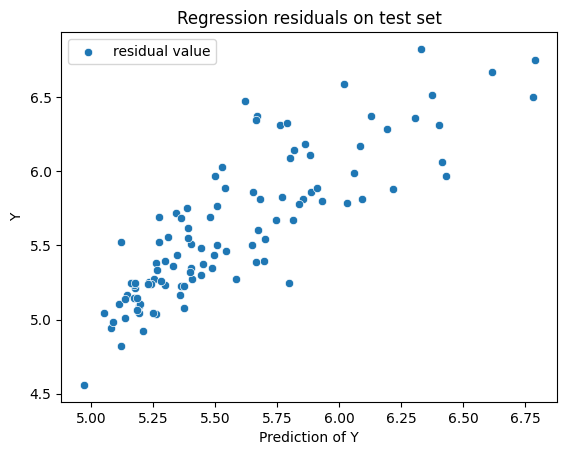

In [56]:
# Fit a regression model
sns.scatterplot(x=preds, y=y_test, label="residual value")
plt.xlabel('Prediction of Y')
plt.ylabel('Y')
plt.legend()
plt.title(f'Regression residuals on test set')
plt.show()

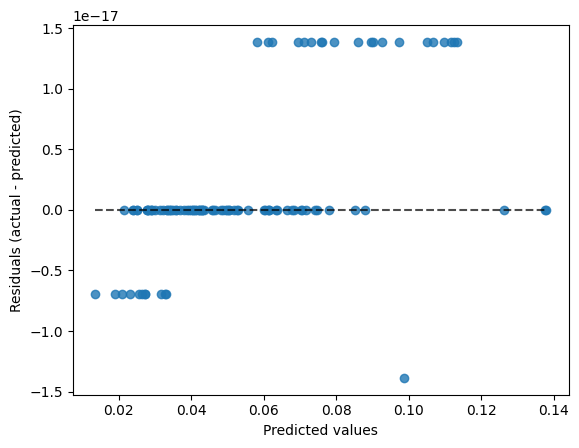

In [57]:
weight_regressor = LinearRegression().fit(np.abs(X_train), add_y_train)
residual_estimates_train = weight_regressor.predict(np.abs(X_train))
residual_estimates_test = weight_regressor.predict(np.abs(X_test))
display = PredictionErrorDisplay(y_true=add_y_test, y_pred=residual_estimates_test)
display.plot()
plt.show()

In [58]:
weights_train = 1 / (weight_regressor.predict(np.abs(X_train)))
weights_test = 1 / (weight_regressor.predict(np.abs(X_test)))

In [59]:
updated_model = LinearRegression().fit(X_train, y_train, sample_weight=weights_train)
updated_preds = updated_model.predict(X_test)

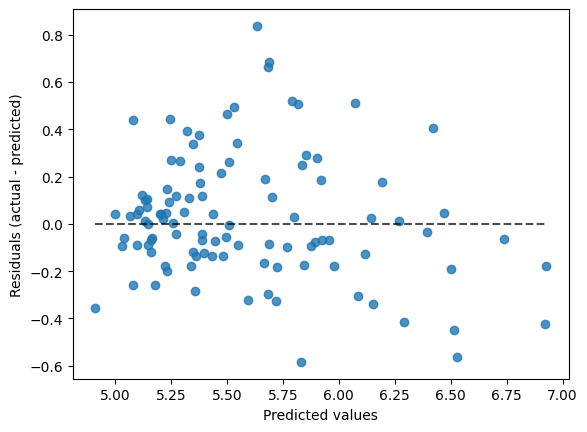

In [60]:
display = PredictionErrorDisplay(
    y_true=y_test, y_pred = updated_preds
    )
display.plot()
plt.show()

In [61]:
print(f"The score of prediction is: {updated_model.score(X_test, y_test)}")

The score of prediction is: 0.6977963110667751


In [62]:
X_test_new = X_test.copy()
X_test_new["const"]=1.

In [63]:
bptest = smd.het_breuschpagan(resid=(y_test-updated_preds), exog_het=X_test_new)
print("lm:", bptest[0], "lm_pvalue:", bptest[1])

lm: 5.020679592355427 lm_pvalue: 0.025046337092884903


In [64]:
wtest = smd.het_white(resid=(y_test-updated_preds), exog=X_test_new)
print("lm:", wtest[0], "lm_pvalue:", wtest[1])

lm: 7.625308797321641 lm_pvalue: 0.022089466817659196


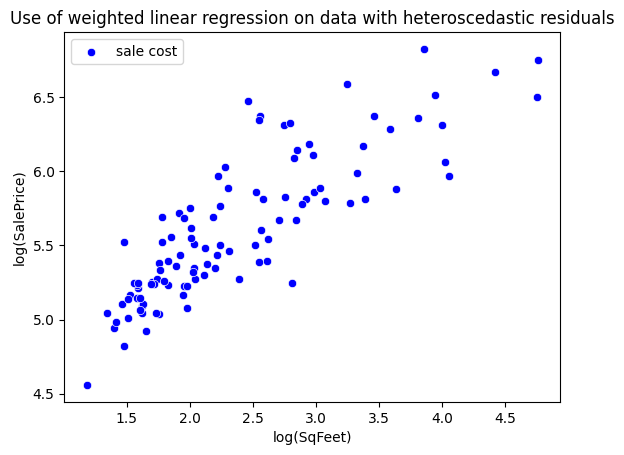

In [65]:
sns.scatterplot(x=X_test["SqFeet"], y=y_test, label='sale cost', color='blue')
# Постройте два графика моделей.
plt.xlabel('log(SqFeet)')
plt.ylabel('log(SalePrice)')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

В нашем случае остатки линейной регрессии симметричны, поэтому мы можем легко перейти на квантильную регрессиию, которая позволяет оценить заданные квантили таргета. Этот регрессор минимизирует MAE, в отличие от стандартной регрессии.

Вопрос: Почему он минимизирует MAE?


In [66]:
from sklearn.linear_model import QuantileRegressor

In [67]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions_test = np.zeros_like(y_test, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train).predict(X_test)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions_test = np.logical_or(
            out_bounds_predictions_test, y_pred >= y_test
        )
    elif quantile == max(quantiles):
        out_bounds_predictions_test = np.logical_or(
            out_bounds_predictions_test, y_pred <= y_test
        )

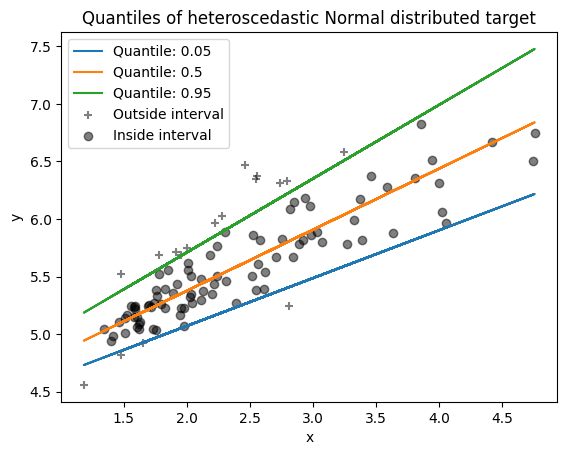

In [68]:
for quantile, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    X_test[out_bounds_predictions_test],
    y_test[out_bounds_predictions_test],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    X_test[~out_bounds_predictions_test],
    y_test[~out_bounds_predictions_test],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")


Почитать: https://www3.nd.edu/~rwilliam/stats2/l25.pdf

**Задание**: Постройте модели, учитывающие гетероскедастичность  для  Anscombe 3 и 4. Предложите сами, как вы будете задавать веса.

In [69]:
quartet_df = pd.read_csv(f"{data_path}/Anscombe_quartet_data.csv")
x = np.array(quartet_df['x123']).reshape((-1, 1))

In [70]:
# Anscombe 3
y = np.array(quartet_df['y3'])

model = LinearRegression().fit(x, y)
residuals = (y - model.predict(x))**2
model_residuals = LinearRegression().fit(np.abs(x), y)

weight_regressor = LinearRegression().fit(np.abs(x), model_residuals.predict(x))
weights = 1 / (weight_regressor.predict(np.abs(x)))

updated_model = LinearRegression().fit(x, y, sample_weight=weights)
y_wls_pred = updated_model.predict(x)

model = LinearRegression().fit(x, y)
y_ols_pred = model_3.predict(x)

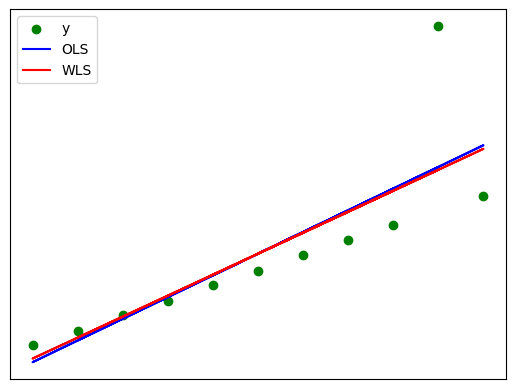

In [71]:
plt.scatter(x, y, color="green")
plt.plot(x, y_ols_pred, color="blue", linestyle="-")
plt.plot(x, y_wls_pred, color="red", linestyle="-")
plt.legend(['y',"OLS", "WLS"])
plt.xticks(())
plt.yticks(())
plt.show()

In [72]:
# Anscombe 3
y = np.array(quartet_df['y4'])

model = LinearRegression().fit(x, y)
residuals = (y - model.predict(x))**2
model_residuals = LinearRegression().fit(np.abs(x), y)

weight_regressor = LinearRegression().fit(np.abs(x), model_residuals.predict(x))
weights = 1 / (weight_regressor.predict(np.abs(x)))

updated_model = LinearRegression().fit(x, y, sample_weight=weights)
y_wls_pred = updated_model.predict(x)

model = LinearRegression().fit(x, y)
y_ols_pred = model_3.predict(x)

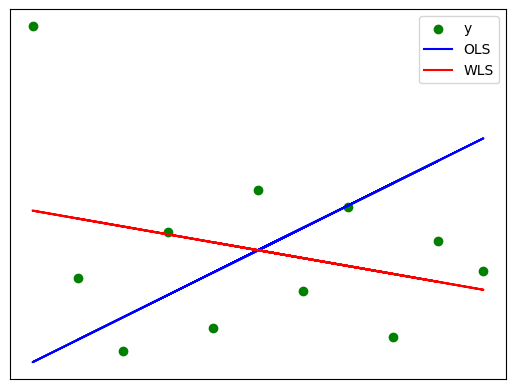

In [73]:
plt.scatter(x, y, color="green")
plt.plot(x, y_ols_pred, color="blue", linestyle="-")
plt.plot(x, y_wls_pred, color="red", linestyle="-")
plt.legend(['y',"OLS", "WLS"])
plt.xticks(())
plt.yticks(())
plt.show()

**Задание**: Постройте синтетические данные, подходящие для линейной модели. Покажите, поможет ли использование QuantileRegressor для удаления выбросов получить лучшую модель и для каких видов гетероскедастичности (выбросы, распределение, "форма" шума)

### Выбросы

In [74]:
np.random.seed(42)
n_samples = 1000
X = np.linspace(0, 10, n_samples)
true_slope = 2.5
true_intercept = 1.0
y_real = true_slope * X + true_intercept

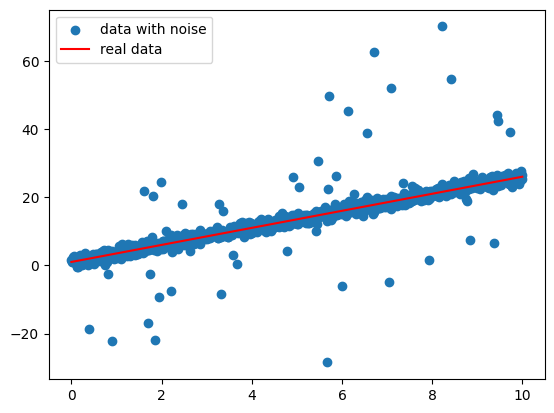

In [75]:
noise = np.random.normal(0, 1, n_samples)
y = y_real + noise

# Добавление выбросов
outlier_indices = np.random.choice(n_samples, 50, replace=False)
y[outlier_indices] += 20 * np.random.randn(50)

plt.scatter(X, y, label="data with noise")
plt.plot(X, y_real, color='red', label="real data")
plt.legend()
plt.show()

In [76]:
X = X.reshape(-1 ,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [77]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions_train = np.zeros_like(y_train, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train).predict(X_train)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions_train = np.logical_or(
            out_bounds_predictions_train, y_pred >= y_train
        )
    elif quantile == max(quantiles):
        out_bounds_predictions_train = np.logical_or(
            out_bounds_predictions_train, y_pred <= y_train
        )

In [78]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

model_filter = LinearRegression().fit(X_train[~out_bounds_predictions_train], y_train[~out_bounds_predictions_train])
y_filter_pred = model_filter.predict(X_test)

print(f"R^2 score: simple: {model.score(X_test, y_test)}, filtered: {model_filter.score(X_test, y_test)}")
print(f"MSE: simple: {mean_squared_error(y_pred, y_test)}, filtered: {mean_squared_error(y_filter_pred, y_test)}")

R^2 score: simple: 0.7210150763383624, filtered: 0.7232166982747033
MSE: simple: 20.619995986084355, filtered: 20.45727237043377


### Распределение

In [79]:
np.random.seed(42)
n_samples = 1000
X = np.linspace(0, 10, n_samples)
noise = np.random.exponential(scale=2, size=1000) 
y_real = true_slope * X + true_intercept

y = 2 * X + 1 + noise

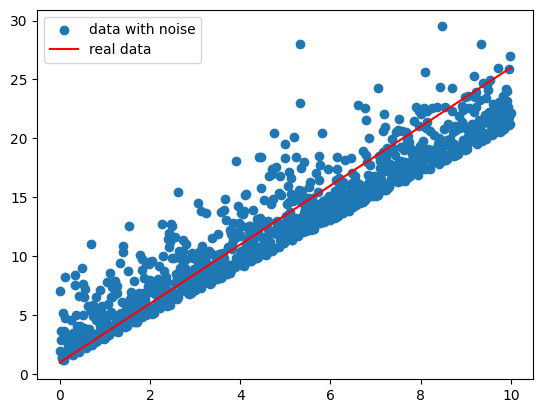

In [80]:
plt.scatter(X, y, label="data with noise")
plt.plot(X, y_real, color='red', label="real data")
plt.legend()
plt.show()

In [81]:
X = X.reshape(-1 ,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [82]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions_train = np.zeros_like(y_train, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train).predict(X_train)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions_train = np.logical_or(
            out_bounds_predictions_train, y_pred >= y_train
        )
    elif quantile == max(quantiles):
        out_bounds_predictions_train = np.logical_or(
            out_bounds_predictions_train, y_pred <= y_train
        )

In [83]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

model_filter = LinearRegression().fit(X_train[~out_bounds_predictions_train], y_train[~out_bounds_predictions_train])
y_filter_pred = model_filter.predict(X_test)

print(f"R^2 score: simple: {model.score(X_test, y_test)}, filtered: {model_filter.score(X_test, y_test)}")
print(f"MSE: simple: {mean_squared_error(y_pred, y_test)}, filtered: {mean_squared_error(y_filter_pred, y_test)}")

R^2 score: simple: 0.9099233735017019, filtered: 0.9108323537687854
MSE: simple: 3.267679173529813, filtered: 3.234704405231246


### Форма "шума"

In [84]:
np.random.seed(42)
n_samples = 1000
X = np.linspace(0, 10, n_samples)
noise = np.random.exponential(scale=2, size=1000) 
y_real = true_slope * X + true_intercept

y = 2 * X + 1 + np.random.normal(0, X, 1000)


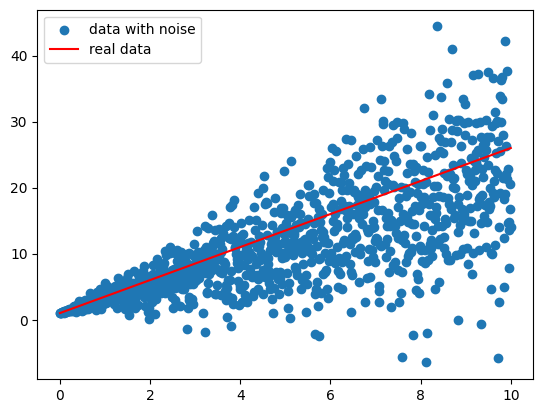

In [85]:
plt.scatter(X, y, label="data with noise")
plt.plot(X, y_real, color='red', label="real data")
plt.legend()
plt.show()

In [86]:
X = X.reshape(-1 ,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [87]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions_train = np.zeros_like(y_train, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train).predict(X_train)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions_train = np.logical_or(
            out_bounds_predictions_train, y_pred >= y_train
        )
    elif quantile == max(quantiles):
        out_bounds_predictions_train = np.logical_or(
            out_bounds_predictions_train, y_pred <= y_train
        )

In [88]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

model_filter = LinearRegression().fit(X_train[~out_bounds_predictions_train], y_train[~out_bounds_predictions_train])
y_filter_pred = model_filter.predict(X_test)

print(f"R^2 score: simple: {model.score(X_test, y_test)}, filtered: {model_filter.score(X_test, y_test)}")
print(f"MSE: simple: {mean_squared_error(y_pred, y_test)}, filtered: {mean_squared_error(y_filter_pred, y_test)}")

R^2 score: simple: 0.5671378766032114, filtered: 0.5674739764631449
MSE: simple: 30.25329771800449, filtered: 30.229807260937573


**Выводы:**
 1. Лучше всего помогает при выбросах
 2. Хуже всего при форме "шума"
 3. В целом, улучшение модели есть везде, но оно достаточно малое

## Мультиколлинеарность

Мультиколлинеарность представляет собой проблему, поскольку она дает менее надежные результаты регрессионной модели. Это связано с более широкими доверительными интервалами (большими стандартными ошибками), которые могут снизить статистическую значимость коэффициентов регрессии. При анализе данных это может привести к ложным впечатлениям.

Рассмотрим уже знакомый нам набор данных, посвященный недвижимости.

In [89]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t")

In [90]:
data["SalePrice"] = np.log(data["SalePrice"])
data.describe()

,SalePrice,SqFeet,Beds,Baths,Air,Garage,Pool,Year,Quality,Style,Lot,Highway
count,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,5.525443,2.260879,3.477927,2.646833,0.831094,2.097889,0.069098,1966.856046,2.186180,3.349328,24.344668,0.021113
std,0.430851,0.711726,1.003835,1.058861,0.375029,0.653405,0.253864,17.620476,0.639923,2.563209,11.681280,0.143900
min,4.430817,0.980000,1.000000,1.000000,0.000000,0.000000,0.000000,1885.000000,1.000000,1.000000,4.560000,0.000000
25%,5.192957,1.701000,3.000000,2.000000,1.000000,2.000000,0.000000,1956.000000,2.000000,1.000000,17.159000,0.000000
50%,5.437644,2.061000,3.000000,3.000000,1.000000,2.000000,0.000000,1966.000000,2.000000,2.000000,22.196000,0.000000
75%,5.814131,2.638000,4.000000,3.000000,1.000000,2.000000,0.000000,1981.000000,3.000000,7.000000,26.777000,0.000000
max,6.824374,5.032000,7.000000,7.000000,1.000000,7.000000,1.000000,1998.000000,3.000000,11.000000,86.830000,1.000000


Обучим базовую модель на одном признаке.

In [91]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6962375875854426
Coefficients are: [0.50970481]


Теперь добавим несколько видов мультиколлинеарности в данных.

### Совершенная коллинеарность

Если две или более независимых переменных имеют между собой линейную связь, то
у нас получается идеальная мультиколлинеарность.
Примеры: включение одной и той же информации дважды (стоимость в рублях и долларах), неправильное использование фиктивных переменных (dummy variables trap) и т. д.
Вот пример идеальной мультиколлинеарности в модели с двумя объясняющими
переменными:
$$
\begin{equation}
y = α_{1} X_1 + \alpha_{2} X_2
\end{equation}
\begin{equation}
X_1 = \beta_1 X_2 + \beta_2
\end{equation}
$$


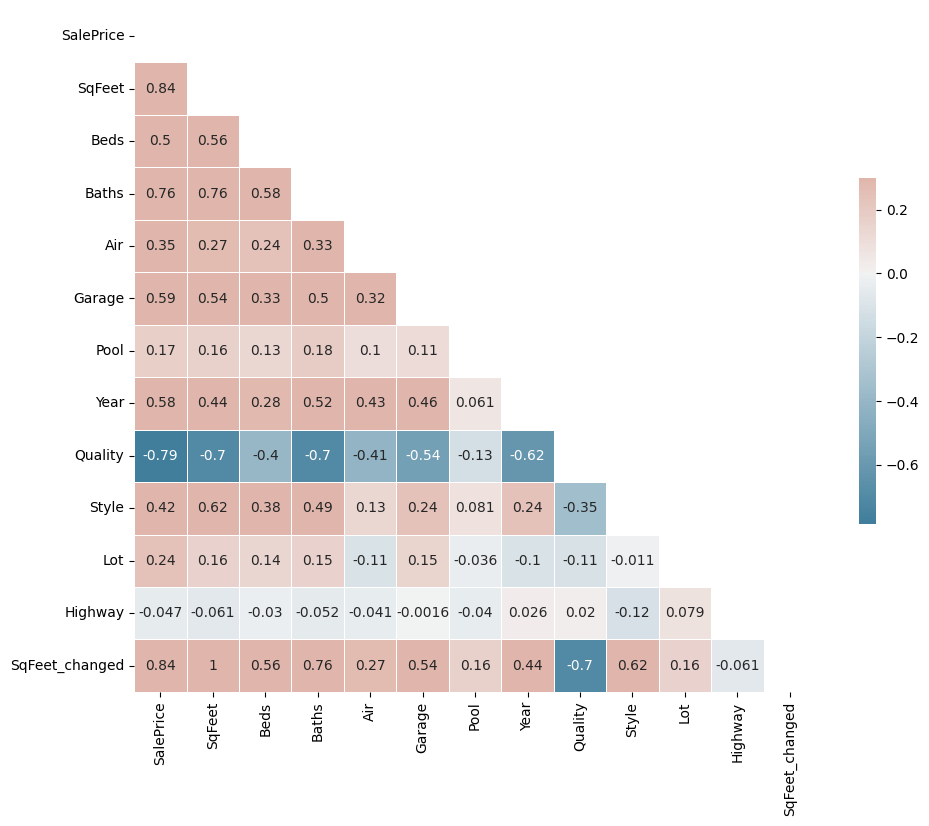

In [92]:
data["SqFeet_changed"] = data["SqFeet"]* 0.8 + 10
corrplot(data)

In [93]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6973611020698613
Coefficients are: [-2.45321038e+13  1.96256831e+13]


In [94]:
data["SqFeet_changed_2"] = data["SqFeet"]* 0.5 - 10
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6767672164053588
Coefficients are: [-2.91970540e+13 -3.66904070e+12  2.51921636e+13]


По идее, совершенная коллинеарность не дает в принципе построить линейную модель, так как невозможно оценить маржинальный эффект воздействия признака на целевую переменную, сохраняя остальные константными.
)
На практике же, даже если конкретная реализация OLS позволит построить коэффициенты, это ведет к тому, что модель перестает быть устойчивой.

### Несовершенная мультиколлинеарность
Несовершенная мультиколлинеарность не нарушает базовых предположений ЛР. Следовательно, теорема Гаусса-Маркова говорит нам, что оценки МНК состоятельны.

Так почему же нас волнует мультиколлинеарность?
2. Дисперсия и стандартные ошибки оценок коэффициентов регрессии будут
увеличиваться. Это означает более низкую t-статистику.
3. На общую точность уравнения регрессии мультиколлинеарность практически не повлияет.
4. Коэффициенты регрессии будут сильно зависеть от признаков. Таким образом, коэффициенты существенно измениться при добавлении или удалении переменных.

In [95]:
data["SqFeet_changed"] = data["SqFeet"] * 0.8 - 20
data["SqFeet_changed_2"] = data["SqFeet_changed"] * 1.5 + 10

data["SqFeet_changed"] += np.random.normal(+1, 0.5, len(data["SqFeet_changed"]))
data["SqFeet_changed_2"] += np.random.normal(-1, 0.5, len(data["SqFeet_changed"]))


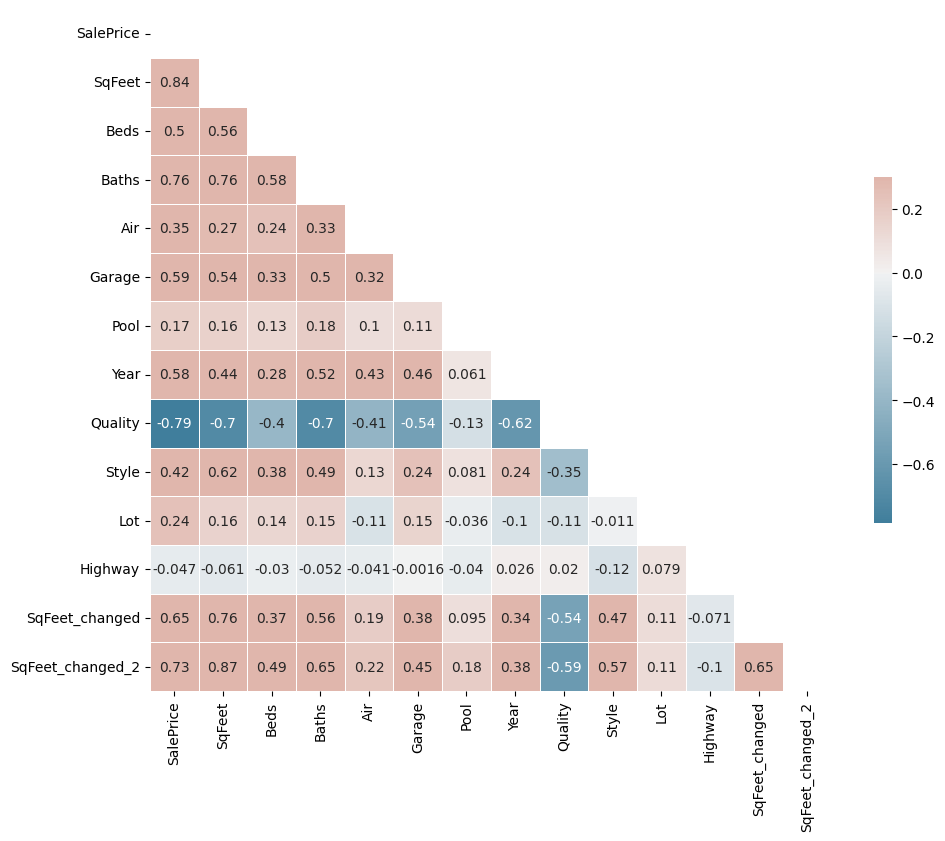

In [96]:
corrplot(data)

In [97]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6946191110410282
Coefficients are: [ 0.03022356 -0.01866375  0.50843712]


In [98]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6953991977397318
Coefficients are: [0.02971829 0.48653237]


Как видно, только один признак имеет большой вес, точность при этом практически не меняется. Однако значимость многих признаков становится неудовлетворительной. Поэтому, если оценить значимость коэффициентов модели, можно обнаружить, что многие признаки просто не нужны. При этом получается, что даже при очень небольшом изменении модели мы можем сделать совершенно противоположные выводы о том, какие признаки важны.

Итак, первый способ найти коллинеарные признаки - оценить значимость коэффициентов (t-statistic + p-value)

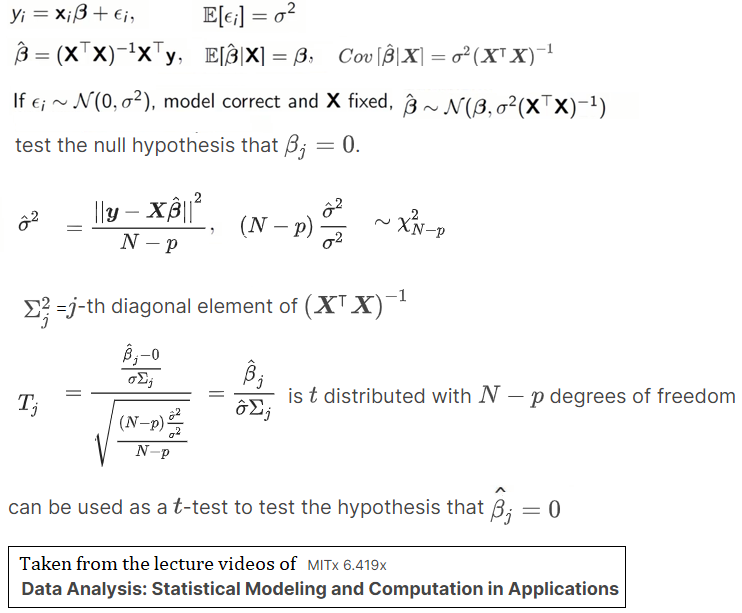

In [99]:
from scipy.stats import t

In [100]:
def get_p_values(model, x: pd.DataFrame, y: pd.DataFrame, a: float = 0.01) -> None:
  beta_hat = [model.intercept_] + model.coef_.tolist()
  n = len(x)
  print(f"Coeffficents: {beta_hat}")
  x_1 = np.column_stack((np.ones(n), x))
  
  y_pred = model.predict(x)
  residuals = y - y_pred
  
  sigma_hat = np.sqrt(np.sum(residuals**2) / (n - x_1.shape[1]))
  
  # estimate the covariance matrix for beta
  beta_cov = np.linalg.inv(x_1.T @ x_1)
  # the t-test statistic for each variable from the formula from above figure
  std_errors = np.sqrt(np.diagonal(beta_cov)) * sigma_hat
  t_vals =  np.array(beta_hat) / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))# your code: beta_hat / (sigma_hat * sqrt(diagonal(beta_cov)))
  # compute 2-sided p-values.
  p_vals = t.sf(np.abs(t_vals), n-x_1.shape[1]) * 2
  print(f"T values: {t_vals}")
  print(f"p-values: {p_vals}")
  print(f"Is valuable: {p_vals < a}")

In [101]:
get_p_values(model, x_test, y_test)

Coeffficents: [np.float64(4.929146005373257), 0.0297182918786423, 0.4865323742442233]
T values: [ 5.91508124  0.67867315 10.51589283]
p-values: [2.84169196e-08 4.98570196e-01 5.04741780e-19]
Is valuable: [ True False  True]


Мультиколлинеарность можно обнаружить и с помощью коэффициента инфляции дисперсии (VIF). Для каждого признака в построенной модели этот коэффициент покащзывает, в какой степени коэфициент "испорчен" коллинеарностью с другими признаками.

В методе VIF мы выбираем каждый признак и сравниваем его со всеми другими признаками. Для каждого признака коэффициент рассчитывается как:

image.png
где R-квадрат — коэффициент детерминации в линейной регрессии этого признака, построенной по всем остальным признакам (1-to-all). Его значение лежит между 0 и 1.
Как мы видим из формулы, чем больше значение R-квадрат, тем больше VIF. Следовательно, больший VIF означает большую корреляцию. Это согласуется с тем фактом, что более высокое значение R-квадрат означает более сильную коллинеарность. Обычно значение VIF выше 5 указывает на высокую мультиколлинеарность.


In [102]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

print(vif_data)

          feature       VIF
0  SqFeet_changed  9.579319
1          SqFeet  9.579319


Как мы видим, наши переменные имеют очень высокие значения VIF, что означает сильную коллинеарность между ними.


In [103]:
features = ['SqFeet', 'Beds', 'Baths', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway']

In [104]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[features], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.8333627167756661
Coefficients are: [ 0.32128686  0.01746661  0.05093416  0.00689765  0.03780231  0.03515141
  0.0033515  -0.11809948 -0.01708504  0.00487232 -0.06529713]


In [105]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

print(vif_data)

    feature         VIF
0    SqFeet   44.314842
1      Beds   21.771159
2     Baths   21.310745
3       Air    7.332373
4    Garage   17.244375
5      Pool    1.114873
6      Year  121.269750
7   Quality   33.782352
8     Style    4.639236
9       Lot    5.769237
10  Highway    1.060519


Теперь можно удалить некоторые признаки. Для этого используются разные способы feature selection. Посмотрим, узменится ли предсказание при удалении некоторых признаков

**Задание**: Постройте модель, удалив лишние признаки. Можно ли получить модель с лучшим скором?

In [106]:
features = ['SqFeet', 'Pool', 'Quality', 'Style', 'Highway']

In [107]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

print(vif_data)

    feature         VIF
0    SqFeet   44.314842
1      Beds   21.771159
2     Baths   21.310745
3       Air    7.332373
4    Garage   17.244375
5      Pool    1.114873
6      Year  121.269750
7   Quality   33.782352
8     Style    4.639236
9       Lot    5.769237
10  Highway    1.060519


In [108]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[features], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.8136632403838615
Coefficients are: [ 0.40543162  0.02873746 -0.22035437 -0.01835185 -0.00756822]
